In [1]:
import csv
import PIL
import pathlib
import fresnel
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from multiprocessing import Process
from scipy.interpolate import interp1d
import time 

In [2]:
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
def delete_1D(new_position,position):
    A=np.array(np.around(new_position,7)).tolist()
    B=np.array(np.around(position,7)).tolist()
    A = [i for i in A if i not in B]
    return A

# Generate the atomic model

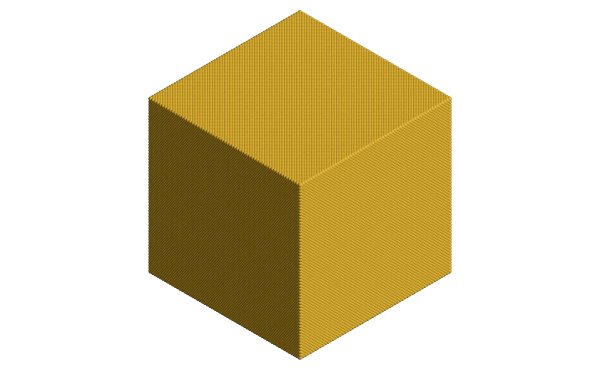

In [3]:
# get the initial dipole position
position = []
for x in range(-30,30):
    for y in range(-30,30):
        for z in range(-30,30):
            position.append([x,y,z])
position = np.array(position)
# create atoms from the cell position
position = neighbors(position).reshape(-1,3)
unique_atoms = np.unique(position,axis=0)

scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position), radius=np.sqrt(2)/2)
geometry.position[:] = position
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
fresnel.preview(scene)

In [4]:
b1_0 = 7;
b2_0 = 16;
v1 = 1.00;
v2 = 0.010;
dt = 0.05

In [6]:
for step in range(0,300):
    b1 = b1_0 + dt*step*v1
    b2 = b2_0 + dt*step*v2
    
    index = (abs(unique_atoms[:,0])+abs(unique_atoms[:,1])<b1)*(abs(unique_atoms[:,0])+abs(unique_atoms[:,1])+abs(unique_atoms[:,2])<b2)
    atom_position = unique_atoms[index]
    
    scene = fresnel.Scene()
    geometry = fresnel.geometry.Sphere(scene, N=len(atom_position), radius=np.sqrt(2)/4)
    geometry.position[:] = atom_position
    geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
    
    out = fresnel.preview(scene)
    image = PIL.Image.fromarray(out[:], mode='RGBA')
    image.save(f"./data/{step}.png")
    np.savetxt(f"./data/atom_{step}.csv",atom_position,delimiter=',')

In [ ]:
atom_position.max()

# Randomly added the atoms between intermediates
# Check if a dipole is formed during the process

In [7]:
# Generate the global initial structure
dipole_position = []
for x in range(-20,20):
    for y in range(-20,20):
        for z in range(-20,20):
            dipole_position.append([x,y,z])
dipole_position = np.array(dipole_position)
dipole_position_neighbor = neighbors(dipole_position)

# read in the initial atomic model 
step = 0
position = np.loadtxt(f"./data/atom_{step}.csv",delimiter=',').tolist()
# get the initial neighbor numbers    
atom_num = []
for index in range(dipole_position_neighbor.shape[1]):
    dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
    atom_num.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))

# create a hashable dictionary for individual diples
atom_num_dic = {}
for i in range(len(dipole_position)):
    atom_num_dic[tuple(dipole_position[i].tolist())] = atom_num[i]
    
selected_dipoles = np.array(list(atom_num_dic.values())) == 14

np.savetxt('./data/initial_dipoles.csv',dipole_position[selected_dipoles],delimiter=',')

In [8]:
# generate 10 different trajectories through random seed
for repeat in range(10):
    np.random.seed(repeat)
    # get the potential dipole position
    dipole_position = []
    for x in range(-20,20):
        for y in range(-20,20):
            for z in range(-20,20):
                dipole_position.append([x,y,z])
    dipole_position = np.array(dipole_position)
    dipole_position_neighbor = neighbors(dipole_position)
    
    # read in the initial atomic model 
    step = 0
    position = np.loadtxt(f"./data/atom_{step}.csv",delimiter=',').tolist()
    # get the initial neighbor numbers    
    atom_num = []
    for index in range(dipole_position_neighbor.shape[1]):
        dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
        atom_num.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))
        
    # create a hashable dictionary for individual diples
    atom_num_dic = {}
    for i in range(len(dipole_position)):
        atom_num_dic[tuple(dipole_position[i].tolist())] = atom_num[i]
        
    for step in range(1,300):
        atom1 = np.loadtxt(f"./data/atom_{step-1}.csv",delimiter=',')
        atom2 = np.loadtxt(f"./data/atom_{step}.csv",delimiter=',')
        if len(atom1) == len(atom2):
            pass
        else:
            print(f"{repeat,step}")
            dipole_change_position = []
            extra_atoms = np.array(delete_1D(atom2,atom1))
            np.random.shuffle(extra_atoms)
            for x in extra_atoms:
                # check how many dipoles will be changed in this single event
                dipole_count = 0
                # check if it is in the surface or at the corner
                index = np.where(np.around(x) != x)[0]
                # if at the surface
                if len(index) == 1:
                    i = index[0]
                    # get the top cell
                    x_tmp = x.copy() # 1
                    x_tmp[i] = x_tmp[i]+0.5
                    atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1

                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                        dipole_change_position.append(x_tmp.tolist())
                        dipole_count = dipole_count + 1
                    # get the bottom cell
                    x_tmp = x.copy() #2
                    x_tmp[i] = x_tmp[i]-0.5
                    atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1

                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                        dipole_change_position.append(x_tmp.tolist())
                        dipole_count = dipole_count + 1
                elif len(index)==3:
                    x_temp = neighbors(x)
                    for i in x_temp[-8:]:
                        atom_num_dic[tuple(i.tolist())] = atom_num_dic[tuple(i.tolist())] + 1
                        # check if the dipoles are fully occupied now
                        if atom_num_dic[tuple(i.tolist())] == 14:
                            dipole_change_position.append(i.tolist())
                            dipole_count = dipole_count + 1
                # if multiple dipoles were changed in adding a single atom, we randominize these their sequence
                # they are equavilent
                if dipole_count >1:
                    print(f"dipole count is {dipole_count}")
                    to_shuffle = dipole_change_position[-dipole_count:].copy()
                    np.random.shuffle(to_shuffle)
                    dipole_change_position[-dipole_count:] = to_shuffle
            np.savetxt(f'./data/dipole_change_{repeat}_{step}.csv',np.array(dipole_change_position),delimiter=',')

(0, 1)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dip

(0, 71)
(0, 81)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(1, 31)
(1, 41)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(1, 131)
(1, 141)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
(1, 151)
(1, 161)
(1, 171)
(2, 1)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(2, 71)
(2, 81)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(3, 31)
(3, 41)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(3, 131)
(3, 141)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
(3, 151)
(3, 161)
(3, 171)
(4, 1)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(4, 71)
(4, 81)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(5, 31)
(5, 41)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(5, 131)
(5, 141)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
(5, 151)
(5, 161)
(5, 171)
(6, 1)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(6, 71)
(6, 81)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(7, 31)
(7, 41)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(7, 131)
(7, 141)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
(7, 151)
(7, 161)
(7, 171)
(8, 1)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(8, 71)
(8, 81)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(9, 31)
(9, 41)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count

(9, 131)
(9, 141)
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
dipole count is 2
(9, 151)
(9, 161)
(9, 171)


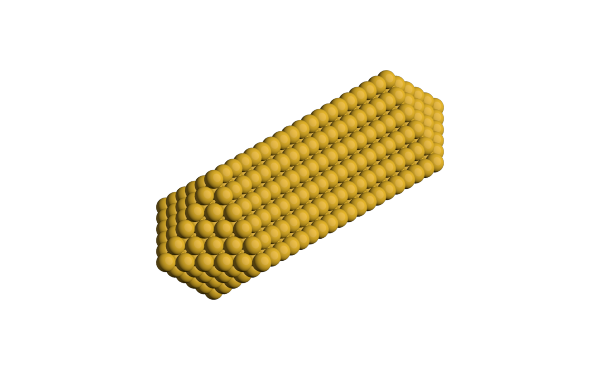

In [9]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(dipole_position[selected_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = dipole_position[selected_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
fresnel.preview(scene)

# Check if the intermediates are correct and consistent

In [10]:
initial_dipoles = np.loadtxt('./data/initial_dipoles.csv',delimiter=',')
flag = 0
for step in range(1,300):
    atom1 = np.loadtxt(f"./data/atom_{step-1}.csv",delimiter=',')
    atom2 = np.loadtxt(f"./data/atom_{step}.csv",delimiter=',')
    if len(atom1) == len(atom2):
        pass
    else:
        intermediates = []
        # read in the data from the 10 different trajecotires
        for repeat in range(10):
            extra_dipoles = np.loadtxt(f'./data/dipole_change_{repeat}_{step}.csv',delimiter=',')
            if len(extra_dipoles) == 0:
                pass
            else:
                intermediates.append(np.vstack((initial_dipoles,extra_dipoles)))
        # check if the intermediates are consistent
        for index in range(1,len(intermediates)):
            a = intermediates[index-1]
            b = intermediates[index]
            a= a[np.lexsort((a[:,2], a[:,1],a[:,0]))]
            b = b[np.lexsort((b[:,2], b[:,1],b[:,0]))]
            if abs(a-b).sum() != 0 :
                print("error!")
                flag = 1
        # upda teh initial dipoles to the intermediates
        initial_dipoles = a

/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_0_11.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_1_11.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_2_11.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_3_11.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_4_11.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_la

/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_0_111.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_1_111.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_2_111.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_3_111.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "./data/dipole_change_4_111.csv"
  if sys.path[0] == '':
/home/yibin/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/ipykern

In [11]:
flag

0